### install

In [ ]:
# pip install wfdb

In [ ]:
# pip install sklearn

In [ ]:
# pip install lightgbm

### import

In [20]:
import ast
import wfdb
import h5py

from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import lightgbm as lgb  

### 데이터 읽기
- input 요소 있음. 콜렙은 c, 데스크탑은 D, 서버에서는 s 라고 치면됨. 대문자 소문자 상관없음.

In [3]:
while True:
    data_location = input("Are you using the colab? Y/N" )

    if data_location.lower() == 'y':
        # Google Colab
        from google.colab import drive
        drive.mount('/content/drive')
        base_path = '/content/drive/MyDrive/ds8/harbud/ecg' + '/'
        base_path_ptb = '/content/drive/MyDrive/ds8/harbud/ecg/ptb_xl_data' + '/'
        base_path_shp = '/content/drive/MyDrive/ds8/harbud/ecg/sph_data' + '/'
        break
    elif data_location.lower() == 'n':
        res = os.getcwd()
        base_path = os.path.join(res)
        base_path_ptb = os.path.join(res, 'ptb_xl_data') + '/'
        base_path_shp = os.path.join(res, 'sph_data') + '/'
        break
    else:
        print('입력값이 올바르지 않습니다. 다시 입력하세요.')


In [4]:
df_ptb_origin = pd.read_csv(base_path_ptb + 'ptbxl_database.csv', encoding='utf-8',index_col='ecg_id')
df_sph_origin = pd.read_csv(base_path_shp + 'metadata.csv', encoding='utf-8', index_col='ECG_ID')

### Ptb_xl의 심박수 데이터 lead1 추출 -> .csv 파일로만듬
 - 신호 및 의료 데이터에 대한 읽기 및 쓰기 기능을 제공하는 wfdb를 이용해서 데이터를 읽음.
 - 각 데이터는 PTBXL_DATABASE에 컬럼으로 만들어 져 있음. 100HZ와 500HZ중 500HZ사용. (테스트 데이터와 맞추기위해)
 - df_lead1.to_csv 로 저장해서 사용하기 편하게 만들어둠

In [ ]:
# #신호 데이터 읽기
# filenames = df_ptb_origin.filename_hr.tolist()    #filename_lr은 100Hz로 저장되어 있는 신호 데이터 파일 경로이고, filename_hr은 500Hz, 여기서는 500Hz만 사용

# df_lead1= pd.DataFrame()

# for ptb_index in tqdm(range(len(df_ptb_origin.index)), 'time'):
#     signal, meta = wfdb.rdsamp(base_path_ptb + filenames[ptb_index])
#     lead1 = signal[:, 0]
#     df_lead1 = pd.concat([df_lead1, pd.DataFrame(lead1).T], axis=0)
# df_lead1.index = df_ptb_origin.index[:]

# df_lead1.to_csv(base_path + r'\custom_file\ashton_ptb_lead1.csv', encoding='UTF-8')


### shp의 심박수 데이터 leead1 추출 -> .csv 파일로만듬

In [26]:
# filenames = sorted(glob(base_path + r"sph_data\records_sph\*.h5"))

# df_sph_origin['filename'] = filenames

# df_lead1_sph = pd.DataFrame()

# for shp_index in tqdm(range(len(df_sph_origin.index)), 'time'):
# # for shp_index in tqdm(range(0, 3), desc='time'):
#     filename = df_sph_origin.filename.tolist()[shp_index]

#     with h5py.File(filename, 'r') as f:
#         signal = f['ecg'][:]
#     lead1 = signal[0, :]

#     if lead1.shape[0] == 5000:
#         lead1_df = pd.DataFrame(lead1)
#     # 데이터의 길이가 5000보다 큰 경우, 연속적인 5000개의 데이터를 랜덤하게 선택
#     else:
#         start_idx = np.random.randint(0, lead1.shape[0] - 4999)  # 마지막 5000개를 포함할 수 있도록 인덱스 설정
#         lead1_df = pd.DataFrame(lead1[start_idx:start_idx+5000])

#     df_lead1_sph = pd.concat([df_lead1_sph, pd.DataFrame(lead1_df).T], axis=0, ignore_index=True)

# df_lead1_sph.index = df_sph_origin.index

# df_lead1_sph.to_csv(base_path + r'\custom_file\ashton_sph_lead1.csv', encoding='UTF-8')


time: 100%|██████████| 25770/25770 [41:15<00:00, 10.41it/s]  


[with문 설명]

with 문은 파일이나 네트워크 연결과 같은 리소스를 사용하는 동안에는 해당 리소스를 안전하게 사용하기 위한 구문입니다. 

with 문을 사용하면 파일이나 네트워크 연결을 열고 사용한 후 자동으로 닫아주는 코드를 작성할 필요가 없습니다.

- h5py.File(filename, 'r')는 HDF5 파일을 '읽기 전용' 모드로 엽니다.
- with 문을 사용하면 블록 안에서 파일을 사용한 후 블록을 벗어나면 파일이 자동으로 닫힙니다. 따라서 파일을 명시적으로 닫아줄 필요가 없습니다.
signal = f['ecg'][:].T는 HDF5 파일에서 'ecg'라는 데이터셋을 가져와서 해당 데이터를 NumPy 배열로 읽어옵니다. 마지막으로 .T는 전치(transpose)를 수행하여 배열의 행과 열을 바꿉니다.
- with 문은 예외 발생 시에도 안전하게 리소스를 정리하는 데 도움을 줍니다. 파일이나 네트워크 연결과 같은 리소스를 사용한 후에는 명시적으로 닫아주는 것이 좋은 프로그래밍 습관이지만, with 문을 사용하면 이를 누락하는 실수를 방지할 수 있습니다.

### 위를 통해서 만들어진 .csv 파일 읽기

In [5]:
df_ptb_lead1 = pd.read_csv(base_path + '/custom_file/ashton_ptb_lead1.csv', index_col=0)

df_sph_lead1 = pd.read_csv(base_path + '/custom_file/ashton_sph_lead1.csv', index_col=0)

### PTB_xl, SHP 데이터 라벨링

In [6]:
#PTB 라벨링

#scp_codes 에서 AFIB에 해당하는 것에 대해서 라벨링
df_ptb_origin.scp_codes = df_ptb_origin.scp_codes.apply(lambda x: ast.literal_eval(x))
df_ptb_origin.scp_codes = df_ptb_origin.scp_codes.apply(lambda x: list(x.keys()))
df_ptb_origin['label'] = df_ptb_origin.scp_codes.apply(lambda arr: 1 if 'AFIB' in arr else 0)

print('df_ptb_origin : ',df_ptb_origin.label.value_counts())
print('-'*15)

#SHP 라벨링

# df_sph_origin['label'] = df_sph_origin['AHA_Code'].apply(lambda x: 1 if '50' in str(x) else 0) - 기존에 잘못된
# 'AHA_Code' 컬럼의 각 값에 대해 '50'이 포함되어 있는지 확인하고, 'label' 컬럼 생성
def check_contains_50(code):
    # 공백을 없애고, ';' 또는 '+'로 분리
    numbers = code.replace(' ', '').replace('+', ';').split(';')
    # '50'이 포함되어 있는지 확인
    return '50' in numbers
# 'label' 컬럼 생성
df_sph_origin['label'] = df_sph_origin['AHA_Code'].apply(check_contains_50).astype(int)


print('df_sph_origin : ',df_sph_origin.label.value_counts())

df_ptb_origin :  label
0    20285
1     1514
Name: count, dtype: int64
---------------
df_sph_origin :  label
0    25095
1      675
Name: count, dtype: int64


### age, sex, label 컬럼과 심박수 데이터 합치기

In [7]:
df_ptb = pd.concat([df_ptb_origin[['age', 'sex', 'label']], df_ptb_lead1], axis=1)

df_sph_lead1.index = df_sph_origin.index
df_sph = pd.concat([df_sph_origin[['Age', 'Sex', 'label']], df_sph_lead1], axis=1)


### 'age', 'sex' 사용 여부에 따른 train, val, test 
- input 요소 있음.
  - 심박수 데이터만 사용할려면 : N
  - age, sex데이터를 함께 사용하려면 : Y
  
(답변시 대문자 소문자 상관없음)

In [8]:
while True:
    age_sex_col=input("Are you using the [age] and [sex] columns? Y/N" )

    if age_sex_col.lower() == 'y':

        X = df_ptb.drop(['label'], axis=1)
        y = df_ptb['label']
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state=42)

        X_test = df_sph.drop(['label'], axis=1)
        y_test = df_sph['label']
        break

    elif age_sex_col.lower() == 'n':

        X = df_ptb.drop(['age', 'sex', 'label'], axis=1)
        y = df_ptb['label']
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state=42)

        X_test = df_sph.drop(['Age', 'Sex', 'label'], axis=1)
        y_test = df_sph['label']
        break
    else:
        print('입력값이 올바르지 않습니다. 다시 입력하세요.')


### 모델선정
 - 작동여부만 확인 하는 모델


In [9]:
model = lgb.LGBMClassifier()
model.fit(X_train, y_train)



[LightGBM] [Info] Number of positive: 1069, number of negative: 14190
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.820568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1274720
[LightGBM] [Info] Number of data points in the train set: 15259, number of used features: 5000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.070057 -> initscore=-2.585814
[LightGBM] [Info] Start training from score -2.585814


LGBMClassifier()

In [10]:
model.score(X_val, y_val)

0.9319571865443425

In [11]:
# 모델로 예측 수행
y_val_pred = model.predict(X_val)

In [12]:
cross_entropy = log_loss(y_val, y_val_pred, labels=[0, 1])
print(f'Cross-Entropy: {cross_entropy}')

Mean Squared Error: 0.06804281345565749
R-squared: -0.07301066447908067


In [13]:

# Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Sensitivity (Recall)
sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
print(f"Sensitivity (Recall): {sensitivity}")

# Specificity
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
print(f"Specificity: {specificity}")

# AUROC
y_prob = model.predict_proba(X_val)[:, 1]  # 클래스 1의 확률
auroc = roc_auc_score(y_val, y_val_pred)
print(f"AUROC: {auroc}")

Confusion Matrix:
[[6089    6]
 [ 439    6]]
Sensitivity (Recall): 0.01348314606741573
Specificity: 0.9990155865463495


AUROC: 0.5062493663068826


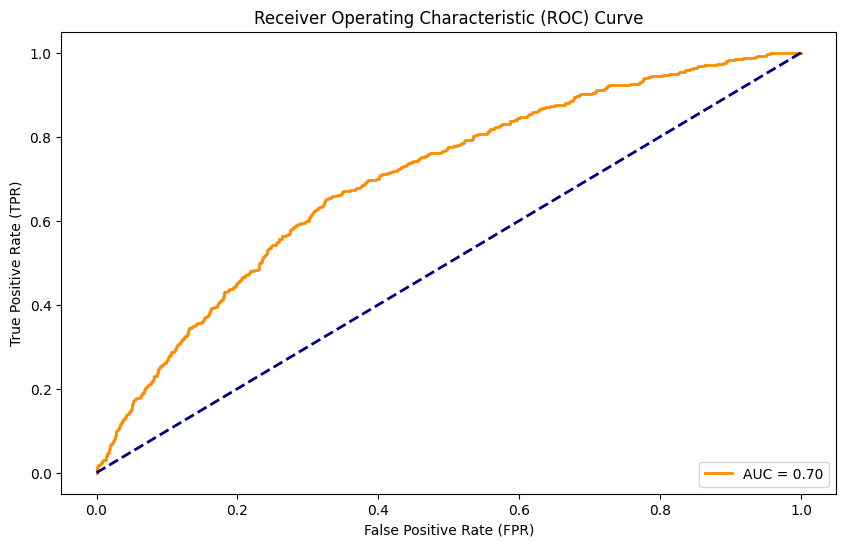

In [14]:

# 예측 확률 얻기
y_val_pred = model.predict_proba(X_val)[:, 1]

# FPR, TPR 계산
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred)

# AUC 계산
roc_auc = auc(fpr, tpr)

# AUROC 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [15]:
model.score(X_test, y_test)


0.9681412495149399

In [16]:
# 모델로 예측 수행
y_test_pred = model.predict(X_test)

In [17]:
cross_entropy = log_loss(y_test, y_test_pred, labels=[0, 1])
print(f'Cross-Entropy: {cross_entropy}')

Mean Squared Error: 0.03185875048506015
R-squared: -0.24901197671072195


In [18]:
# Confusion Matrix
conf_matrix_test = confusion_matrix(y_test, model.predict(X_test))
print("Confusion Matrix (Test):")
print(conf_matrix_test)

# Sensitivity (Recall)
sensitivity_test = conf_matrix_test[1, 1] / (conf_matrix_test[1, 0] + conf_matrix_test[1, 1])
print(f"Sensitivity (Recall) - Test: {sensitivity_test}")

# Specificity
specificity_test = conf_matrix_test[0, 0] / (conf_matrix_test[0, 0] + conf_matrix_test[0, 1])
print(f"Specificity - Test: {specificity_test}")

# AUROC
y_prob_test = model.predict_proba(X_test)[:, 1]  # Class 1's probability
auroc_test = roc_auc_score(y_test, y_prob_test)
print(f"AUROC - Test: {auroc_test}")


Confusion Matrix (Test):
[[24938   157]
 [  664    11]]
Sensitivity (Recall) - Test: 0.016296296296296295
Specificity - Test: 0.9937437736600917
AUROC - Test: 0.6682002759882815


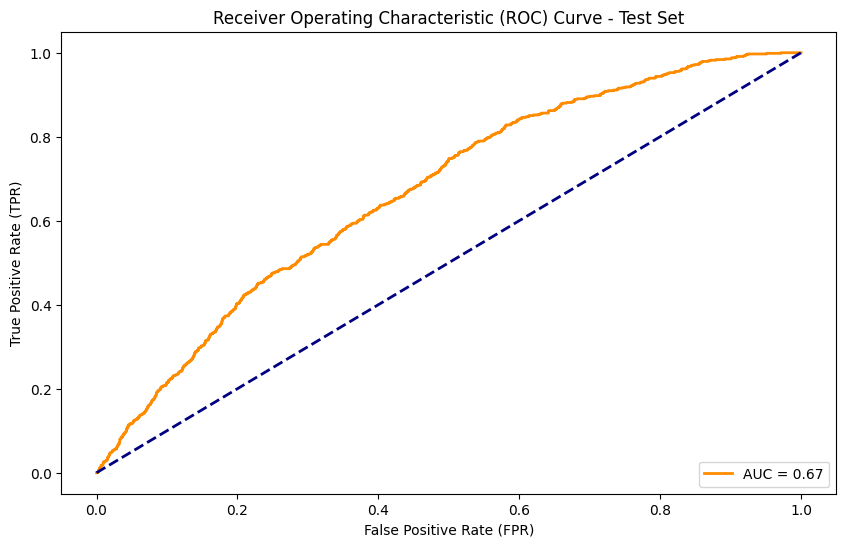

In [19]:

# 예측 확률 얻기
y_test_pred = model.predict_proba(X_test)[:, 1]

# FPR, TPR 계산
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_pred)

# AUC 계산
roc_auc_test = auc(fpr_test, tpr_test)

# AUROC 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'AUC = {roc_auc_test:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Set')
plt.legend(loc='lower right')
plt.show()
